# Trying out on a simple 1-D heat boundary 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf

from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable



Using TensorFlow 2 backend.

Instructions for updating:
non-resource variables are not supported in the long term


We will try the deepXDE on a very simple 1-D heat equation of the following with zero temp at boundary

$
\begin{align}
& \frac{\partial u}{\partial t}  = k \frac{\partial ^2 u}{\partial x^2}  \\
u(x,0) = f(x) \hspace{1em} & u(0,t) = u(L,t) = 0
\end{align}
$

where $f(x) = 6 \text{sin} \left( \frac{\pi x}{L} \right)$

The exact solution is given by:
$u(x,t) = 6 \text{sin} \left( \frac{\pi x}{L} \right) \text{e}^{-k\left(\frac{\pi}{K}\right)^2 t} $

In [2]:
k = 1.22e-3

In [3]:
def pde(x,y):
    
    du_t = dde.grad.jacobian(y, x, j=1)
    du_xx = k * dde.grad.hessian(y, x, j=0)

    return du_t - du_xx 

def func(x):
    return 6 * np.sin(np.pi * x[:,0:1])

geom = dde.geometry.Interval(0, 1)

timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)
bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, func, lambda _, on_initial: on_initial)

data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    num_test=10000
)

layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)
# net.outputs_modify(lambda x, y: x * y)

model = dde.Model(data, net)

model.compile("adam", lr=0.001, loss_weights=[0.1,0.2,0.4])
losshistory, train_state = model.train(epochs=2000)


Compiling model...
Building feed-forward neural network...
'build' took 0.126976 s



/home/syamil/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/syamil/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 3.350013 s

Initializing variables...
Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.28e-03, 6.97e-04, 7.10e+00]    [1.31e-03, 0.00e+00, 0.00e+00]    []  
1000      [7.45e-04, 2.52e-04, 7.76e-04]    [3.16e-04, 0.00e+00, 0.00e+00]    []  
2000      [1.80e-04, 4.71e-05, 8.88e-05]    [8.77e-05, 0.00e+00, 0.00e+00]    []  

Best model at step 2000:
  train loss: 3.16e-04
  test loss: 8.77e-05
  test metric: []

'train' took 21.512577 s



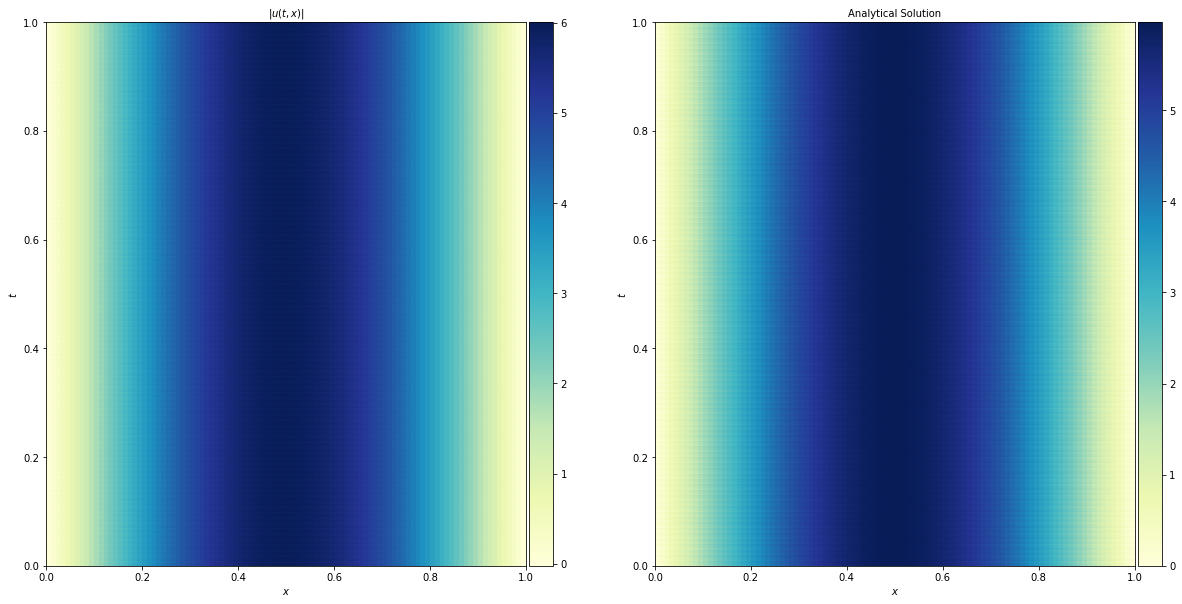

In [4]:
X_train, y_train, X_test, y_test, best_y, best_ystd = train_state.packed_data()
t = X_test.T[0].flatten()
x = X_test.T[1].flatten()

X, T = np.meshgrid(t,x)

T_pred = griddata(X_test, best_y.flatten(), (T, X), method='cubic')

fig, axs = plt.subplots(ncols=2,figsize=(20, 10))
h = axs[0].imshow(T_pred.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[0, 1, 0, 1], 
                  origin='lower', aspect='auto')

divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
axs[0].set_xlabel('$x$')
axs[0].set_ylabel('$t$')
axs[0].set_title('$|u(t,x)|$', fontsize = 10)

# Plot analytical solution

points = np.linspace(0, 1, num=10000)

def solution(x,t):
    return 6 * np.sin(np.pi * x)*np.exp(-k*np.pi**2*t)

z = solution(points,points)

X_p, T_p = np.meshgrid(points,points)
X_star = np.hstack((X_p, T_p))

T_anal = griddata(X_test, z, (X, T), method='cubic')

h = axs[1].imshow(T_anal.T, interpolation='nearest', cmap='YlGnBu', 
                  extent=[0, 1, 0, 1], 
                  origin='lower', aspect='auto')

divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
axs[1].set_xlabel('$x$')
axs[1].set_ylabel('$t$')
# leg = ax.legend(frameon=False, loc = 'best')
#    plt.setp(leg.get_texts(), color='w')
axs[1].set_title('Analytical Solution', fontsize = 10)
plt.show()